In [5]:
import numpy as np
import pandas as pd
import Perceptron.perceptron as pn
from Perceptron.data_gen import Universe, separable_regression, data_distribution
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, zero_one_loss
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import math
from tqdm import tqdm
import argparse
import random
from scipy.io import arff
import matplotlib.pyplot as plt


## Data Corruption Experiment
from typing import List, Tuple
import random


In [6]:
# Utility Functions
def pickle_data(
    root_dir, 
    results,
    args):
    
    # Make sure it is a directory!
    if root_dir[-1] != '/':
        root_dir += '/'
    
    # Create pickle structure
    pkl = {
        'results': dict(results),
        'args':    args,
    }
    
    
    # Create file name

    file_name = f"{args.label}_test_size_{args.test_size}.pkl"
    
    with open(f"{root_dir}{file_name}", 'wb') as pkl_file:
        pickle.dump(pkl, pkl_file)


In [7]:
# Experiment required functions
def sample_data(
    lows:      List[float],
    highs:     List[float],
    n_samples: int,
    seed:      int=None
) -> List[List[int]]:
    """Sample uniform distribution bounded by lows and highs
    
        Using a uniform distribution, perform sampling over the 
    distribution such that the space the distribution is sampling will 
    be bounded by the given bounds from the lows and highs. Lows and 
    highs will be arrays that contain the minimum and maximum values 
    per dimension on the data to be samples. For example, if we have 4 
    values in both lows and highs, then, at the time of sampling n_samples
    samples we will have n_samples of 4 attributes each: (n_samples, 4).
    """
    
    assert len(lows) == len(highs), f"Non-matching lows and highs: {len(lows) != {len(highs)}}"
    
    rng = np.random.default_rng(seed)
    data_shape = (n_samples, len(lows)) # See assertion #1
    data = rng.uniform(lows, highs, data_shape)
    return data

# splitting the dataset into bins can be done with: np.split(data, n_buckets)
# Recommend shuffling beforehand tho.

class Concept:
    """Label given data
    Using a model as truth, label given data.
    """
    def __init__(self, model):
        self.model = model
        
    def __call__(self, X):
        return self.model.solve(X)
    
    
class NPolynomial:
    
    def __init__(self, 
                 n:    int, 
                 low:  float=0, 
                 high: float=1, 
                 seed: int=42
                ):
        self.n     = n
        self.seed  = seed
        self.low   = low
        self.high  = high
        rng        = np.random.default_rng(seed)
        self.coeff = rng.uniform(low, high, (n, 1))
        self.exps  = [exp for exp in range(n)[::-1]]
        
    def solve(self, vals):
        var = np.power(vals, self.exps)
        activation = np.sign(var @ self.coeff)                                        
        activation[activation == 0] = -1
        return activation

# Data Corruption Experiment
## Synthetic Dataset -- Linearly Separable

In [8]:
verbose = 1


# Experiment
# Set up learning concept
ins = 4 + 1 # +1 because of bias!
rng = np.random.default_rng(42) # For reproducibility
W = np.concatenate([ rng.uniform(-100, 100, (ins, 1)) ])

# Create dataset
# Lower and upper bounds for data distribution PER dimension
lows  = [-10, -10, -10, -10] + [1] 
highs = [10, 10, 10, 10] + [1]

# Number of samples for training and testing
n_samples = 1000
n_test    = n_samples//6

# How many buckets to split into
n_buckets = 100

# Training
n_runs    = 100
seed      = 42

# As in number of dimensions of dataset
n_attribs = ins 

# Perceptron learning rate
eta       = 0.5

# Maximum number of iterations before perceptron said to have converged.
max_iter  = 2000
rand_seed = None

# Will have n_runs scores per bucket size used for training.
history   = {buckets: [] for buckets in range(1, n_buckets)}

rng = np.random.default_rng(seed) # For reproducibility
for run in range(n_runs):
    if verbose > 0:
        print(f"Run #{run}")
        
    '''Choose some concept to learn'''
    truth = pn.PocketPerceptron()
    truth.pi = truth.W = W
    c = Concept(truth) # Concept is just a wrapper. Do truth.predict for same result
    
    '''Sample training and testing data'''
    assert len(lows) == len(highs) == ins, \
        f"Data dimensions do not match concept's: {ins} vs {len(lows)} vs {len(highs)}"
    # We sample separately the data from the uniform distribution. Then, we label according
    # to the concept (perceptron with weights W)
    train_data   = sample_data(lows, highs, n_samples=n_samples, seed=42)
    train_data   = np.split(train_data, n_buckets)
    train_data   = np.array(train_data) # Helps in keeping bucket structure
    train_labels = c(train_data)
    test_data    = sample_data(lows, highs, n_samples=n_test, seed=42) # no need for 0.2 tho!
    test_labels  = c(test_data)
    
    '''Experiment algorithm'''
    for buckets in range(1, n_buckets):
        if verbose > 1:
            print(f"\tBuckets used: {buckets}")
        # Choose buckets to be used.
        indices        = rng.choice(range(1, n_buckets), size=buckets, replace=False)
        X = np.concatenate(train_data[indices])
        Y = np.concatenate(train_labels[indices])
        if verbose > 2:
            print(f"\tData points used: {len(X)}")
        
        # Train model
        model = pn.PocketPerceptron(
            input    =n_attribs,
            eta      =eta,
            max_iter =max_iter,
            rand_seed=rand_seed,
        )
        model.train(X, Y)
        pred = model.solve(test_data)
        
        # Measure zero-one & store
        score = accuracy_score(pred, test_labels)
        history[buckets].append(score)
        
        if verbose > 3:
            print(f"\t\tScore: {score}")
        
        
        
history_syn_lin = history

# Note: train_data has buckets, test_data does not: only instances.

Run #0
Run #1
Run #2
Run #3
Run #4
Run #5
Run #6
Run #7
Run #8
Run #9
Run #10
Run #11
Run #12
Run #13
Run #14
Run #15
Run #16
Run #17
Run #18
Run #19
Run #20
Run #21
Run #22
Run #23
Run #24
Run #25
Run #26
Run #27
Run #28
Run #29
Run #30
Run #31
Run #32
Run #33
Run #34
Run #35
Run #36
Run #37
Run #38
Run #39
Run #40
Run #41
Run #42
Run #43
Run #44
Run #45
Run #46
Run #47
Run #48
Run #49
Run #50
Run #51
Run #52
Run #53
Run #54
Run #55
Run #56
Run #57
Run #58
Run #59
Run #60
Run #61
Run #62
Run #63
Run #64
Run #65
Run #66
Run #67
Run #68
Run #69
Run #70
Run #71
Run #72
Run #73
Run #74
Run #75
Run #76
Run #77
Run #78
Run #79
Run #80
Run #81
Run #82
Run #83
Run #84
Run #85
Run #86
Run #87
Run #88
Run #89
Run #90
Run #91
Run #92
Run #93
Run #94
Run #95
Run #96
Run #97
Run #98
Run #99


([<matplotlib.axis.YTick at 0x7f8357f0ab50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

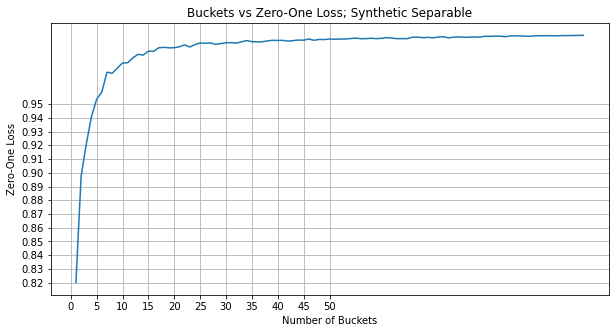

In [9]:
pd.DataFrame(history_syn_lin).mean().plot(figsize=(10, 5))
plt.grid(True)
plt.title("Buckets vs Zero-One Loss; Synthetic Separable")
plt.xlabel("Number of Buckets")
plt.ylabel("Zero-One Loss")
plt.xticks(range(0, 51, 5))
plt.yticks(np.linspace(0.82, 0.95, 14))

<AxesSubplot:>

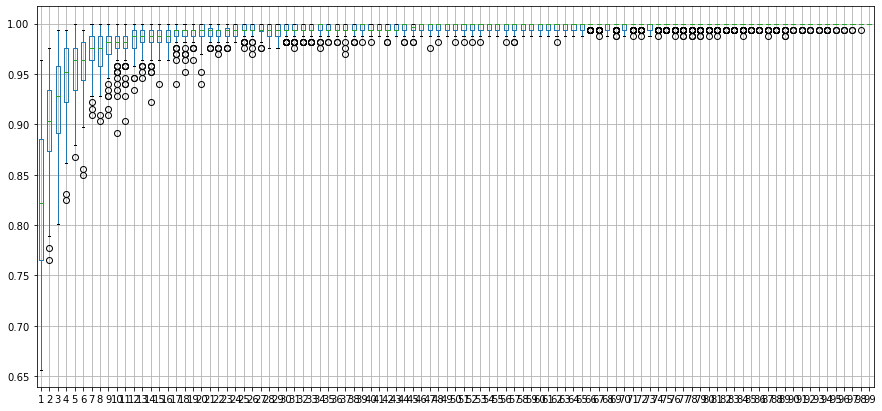

In [10]:
pd.DataFrame(history_syn_lin).boxplot(figsize=(15, 7))

### Save results

In [17]:
import pickle

syn_lin_pickle = {
    'history':    history_syn_lin,
    'n_data':     1000*1.2,
    'test_split': 0.2,
    'n_runs':     n_runs,
    'n_buckets':  n_buckets,
    'max_iter':   max_iter,
    'n_attribs':  4+1,
}

with open('lin_results.pkl', 'wb') as pkl:
    pickle.dump(syn_lin_pickle, pkl)
    
#with open('lin_results.pkl', 'rb') as pkl:
#    some_dict = pickle.load(pkl)

## Synthetic Dataset -- Non-Linearly Separable

In [11]:
verbose = 1

# Experiment
# Set up learning concept
ins = 4 + 1 # +1 because of bias!
rng = np.random.default_rng(42) # For reproducibility
W = np.concatenate([ rng.uniform(-100, 100, (ins, 1)) ])

# Create dataset
# Lower and upper bounds for data distribution PER dimension
lows  = [-10, -10, -10, -10] + [1] 
highs = [10, 10, 10, 10] + [1]

# Number of samples for training and testing
n_samples = 1000
n_test    = n_samples//6

# How many buckets to split into
n_buckets = 100

# Training
n_runs    = 100
seed      = 42

# As in number of dimensions of dataset
n_attribs = ins 

# Perceptron learning rate
eta       = 1 

# Maximum number of iterations before perceptron said to have converged.
max_iter  = 2000
rand_seed = None

# Will have n_runs scores per bucket size used for training.
history   = {buckets: [] for buckets in range(1, n_buckets)}

rng = np.random.default_rng(seed) # For reproducibility
for run in range(n_runs):
    if verbose > 0:
        print(f"Run #{run}")
        
    '''Choose some concept to learn'''
    truth = NPolynomial(ins, -10, 10)
    c = Concept(truth) # Concept is just a wrapper. Do truth.predict for same result
    
    '''Sample training and testing data'''
    assert len(lows) == len(highs) == ins, \
        f"Data dimensions do not match concept's: {ins} vs {len(lows)} vs {len(highs)}"
    # We sample separately the data from the uniform distribution. Then, we label according
    # to the concept (perceptron with weights W)
    train_data   = sample_data(lows, highs, n_samples=n_samples, seed=42)
    train_data   = np.split(train_data, n_buckets)
    train_data   = np.array(train_data) # Helps in keeping bucket structure
    train_labels = c(train_data)
    test_data    = sample_data(lows, highs, n_samples=n_test, seed=42) # no need for 0.2 tho!
    test_labels  = c(test_data)
    
    '''Experiment algorithm'''
    for buckets in range(1, n_buckets):
        if verbose > 1:
            print(f"\tBuckets used: {buckets}")
        # Choose buckets to be used.
        indices        = rng.choice(range(1, n_buckets), size=buckets, replace=False)
        X = np.concatenate(train_data[indices])
        Y = np.concatenate(train_labels[indices])
        if verbose > 2:
            print(f"\tData points used: {len(X)}")
        
        # Train model
        model = pn.PocketPerceptron(
            input    =n_attribs,
            eta      =eta,
            max_iter =max_iter,
            rand_seed=rand_seed,
            ignore_flag=True,
        )
        model.train(X, Y)
        pred = model.solve(test_data)
        
        # Measure zero-one & store
        score = accuracy_score(pred, test_labels)
        history[buckets].append(score)
        
        if verbose > 3:
            print(f"\t\tScore: {score}")
        
        
        
history_non_syn_lin = history

# Note: train_data has buckets, test_data does not: only instances.

Run #0
Run #1
Run #2
Run #3
Run #4
Run #5
Run #6
Run #7
Run #8
Run #9
Run #10
Run #11
Run #12
Run #13
Run #14
Run #15
Run #16
Run #17
Run #18
Run #19
Run #20
Run #21
Run #22
Run #23
Run #24
Run #25
Run #26
Run #27
Run #28
Run #29
Run #30
Run #31
Run #32
Run #33
Run #34
Run #35
Run #36
Run #37
Run #38
Run #39
Run #40
Run #41
Run #42
Run #43
Run #44
Run #45
Run #46
Run #47
Run #48
Run #49
Run #50
Run #51
Run #52
Run #53
Run #54
Run #55
Run #56
Run #57
Run #58
Run #59
Run #60
Run #61
Run #62
Run #63
Run #64
Run #65
Run #66
Run #67
Run #68
Run #69
Run #70
Run #71
Run #72
Run #73
Run #74
Run #75
Run #76
Run #77
Run #78
Run #79
Run #80
Run #81
Run #82
Run #83
Run #84
Run #85
Run #86
Run #87
Run #88
Run #89
Run #90
Run #91
Run #92
Run #93
Run #94
Run #95
Run #96
Run #97
Run #98
Run #99


([<matplotlib.axis.YTick at 0x7f83572a0580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

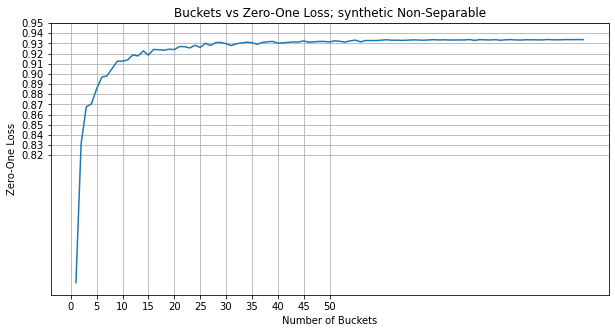

In [12]:
pd.DataFrame(history_non_syn_lin).mean().plot(figsize=(10, 5))
plt.grid(True)
plt.title("Buckets vs Zero-One Loss; synthetic Non-Separable")
plt.xlabel("Number of Buckets")
plt.ylabel("Zero-One Loss")
plt.xticks(range(0, 51, 5))
plt.yticks(np.linspace(0.82, 0.95, 14))

<AxesSubplot:>

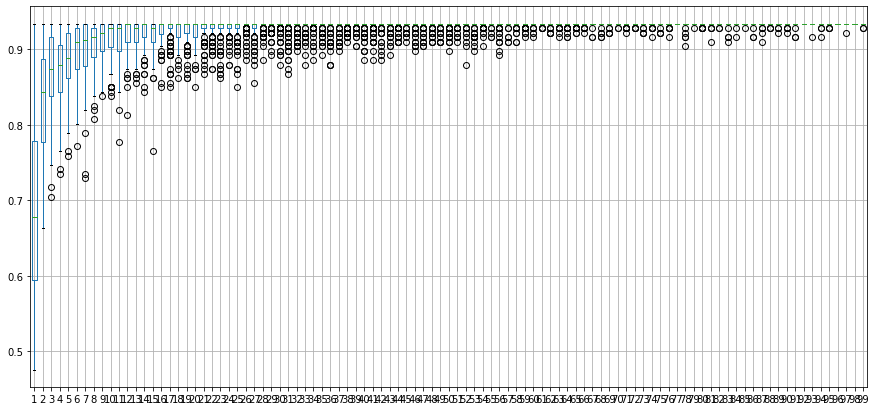

In [13]:
pd.DataFrame(history_non_syn_lin).boxplot(figsize=(15, 7))

### Save results

In [16]:
import pickle

non_syn_lin_pickle = {
    'history':    history_non_syn_lin,
    'n_data':     1000*1.2,
    'test_split': 0.2,
    'n_runs':     n_runs,
    'n_buckets':  n_buckets,
    'max_iter':   max_iter,
    'n_attribs':  4+1,
}

with open('non_lin_results.pkl', 'wb') as pkl:
    pickle.dump(non_syn_lin_pickle, pkl)
    
#with open('non_lin_results.pkl', 'rb') as pkl:
#    some_dict = pickle.load(pkl)

## Real World Data -- Skin/No Skin Non-Separable

In [19]:
verbose = 2

data = arff.loadarff('./datasets/skinNoSkin.arff')
skin = pd.DataFrame(data[0])
skin['bias'] = 1
# Data cleaning
skin.replace(b'1', -1, inplace=True)
skin.replace(b'2', 1, inplace=True)
X = skin.drop('Class', axis=1).assign(bias=1)
X = X.to_numpy()
y = skin.Class



n_samples = X.shape[0]
n_attribs = ins = X.shape[1]

# Experiment
# Set up learning concept
rng = np.random.default_rng(42) # For reproducibility
# Create dataset


# How many buckets to split into
n_buckets = 100
# Training
n_runs    = 100
seed      = 42
# As in number of dimensions of dataset
n_attribs = ins = 4 # Unique to Skin/Noskin dataset
# Perceptron learning rate
eta       = 1 
# Maximum number of iterations before perceptron said to have converged.
max_iter  = 2000
rand_seed = None
# Will have n_runs scores per bucket size used for training.
history   = {buckets: [] for buckets in range(1, n_buckets)}

rng = np.random.default_rng(seed) # For reproducibility
for run in range(n_runs):
    if verbose > 0:
        print(f"Run #{run}")
        

    '''Sample training and testing data'''
    #assert len(lows) == len(highs) == ins, \
    #    f"Data dimensions do not match concept's: {ins} vs {len(lows)} vs {len(highs)}"
    # We split the data so to have statistical significance
    sss = StratifiedShuffleSplit(n_splits=1, test_size=100000, train_size=500)
    for train_i, test_i in sss.split(X, y):
        train_data, train_labels = X[train_i], y[train_i]
        test_data, test_labels = X[test_i], y[test_i]
    # We just need to bucket the data now
    train_data   = np.array_split(train_data, n_buckets) # split rises exception if not even!
    train_data   = np.array(train_data) # Helps in keeping bucket structure
    train_labels = np.array_split(train_labels, n_buckets)
    train_labels = np.array(train_labels)
    
    '''Experiment algorithm'''
    for buckets in range(1, n_buckets):
        if verbose > 1:
            print(f"\tBuckets used: {buckets}")
        # Choose buckets to be used.
        indices = rng.choice(range(1, n_buckets), size=buckets, replace=False)
        E       = np.concatenate(train_data[indices])
        C       = np.concatenate(train_labels[indices])
        if verbose > 2:
            print(f"\tData points used: {len(E)}")
        
        # Train model
        model = pn.PocketPerceptron(
            input    =n_attribs,
            eta      =eta,
            max_iter =max_iter,
            rand_seed=rand_seed,
            ignore_flag = True
        )
        model.train(E, C)
        pred = model.solve(test_data)
        
        # Measure zero-one & store
        score = accuracy_score(pred, test_labels)
        history[buckets].append(score)
        
        if verbose > 3:
            print(f"\t\tScore: {score}")
        
        
        
skin_history = history

# Note: train_data has buckets, test_data does not: only instances.

Run #0
	Buckets used: 1
	Buckets used: 2
	Buckets used: 3
	Buckets used: 4
	Buckets used: 5
	Buckets used: 6
	Buckets used: 7
	Buckets used: 8
	Buckets used: 9
	Buckets used: 10
	Buckets used: 11
	Buckets used: 12
	Buckets used: 13
	Buckets used: 14
	Buckets used: 15
	Buckets used: 16
	Buckets used: 17
	Buckets used: 18
	Buckets used: 19
	Buckets used: 20
	Buckets used: 21
	Buckets used: 22
	Buckets used: 23
	Buckets used: 24
	Buckets used: 25
	Buckets used: 26
	Buckets used: 27
	Buckets used: 28
	Buckets used: 29
	Buckets used: 30
	Buckets used: 31
	Buckets used: 32
	Buckets used: 33
	Buckets used: 34
	Buckets used: 35
	Buckets used: 36
	Buckets used: 37
	Buckets used: 38
	Buckets used: 39
	Buckets used: 40
	Buckets used: 41
	Buckets used: 42
	Buckets used: 43
	Buckets used: 44
	Buckets used: 45
	Buckets used: 46
	Buckets used: 47
	Buckets used: 48
	Buckets used: 49
	Buckets used: 50
	Buckets used: 51
	Buckets used: 52
	Buckets used: 53
	Buckets used: 54
	Buckets used: 55
	Buckets use

	Buckets used: 61
	Buckets used: 62
	Buckets used: 63
	Buckets used: 64
	Buckets used: 65
	Buckets used: 66
	Buckets used: 67
	Buckets used: 68
	Buckets used: 69
	Buckets used: 70
	Buckets used: 71
	Buckets used: 72
	Buckets used: 73
	Buckets used: 74
	Buckets used: 75
	Buckets used: 76
	Buckets used: 77
	Buckets used: 78
	Buckets used: 79
	Buckets used: 80
	Buckets used: 81
	Buckets used: 82
	Buckets used: 83
	Buckets used: 84
	Buckets used: 85
	Buckets used: 86
	Buckets used: 87
	Buckets used: 88
	Buckets used: 89
	Buckets used: 90
	Buckets used: 91
	Buckets used: 92
	Buckets used: 93
	Buckets used: 94
	Buckets used: 95
	Buckets used: 96
	Buckets used: 97
	Buckets used: 98
	Buckets used: 99
Run #5
	Buckets used: 1
	Buckets used: 2
	Buckets used: 3
	Buckets used: 4
	Buckets used: 5
	Buckets used: 6
	Buckets used: 7
	Buckets used: 8
	Buckets used: 9
	Buckets used: 10
	Buckets used: 11
	Buckets used: 12
	Buckets used: 13
	Buckets used: 14
	Buckets used: 15
	Buckets used: 16
	Buckets use

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(skin_history).mean().plot(figsize=(10, 5))
plt.grid(True)
plt.title("Buckets vs Zero-One Loss; Skin/No Skin")
plt.xlabel("Number of Buckets")
plt.ylabel("Zero-One Loss")
plt.xticks(range(0, 51, 5))
plt.yticks(np.linspace(0.82, 0.95, 14))

In [ ]:
pd.DataFrame(skin_history).boxplot(figsize=(15, 7))

## Real World Data -- Iris Separable

In [24]:
verbose = 2

from sklearn import datasets
iris = datasets.load_iris()

data = pd.DataFrame(iris.data)
data['bias'] = 1
targets = pd.DataFrame(iris.target)

targets.replace(0, -1, inplace=True)
targets.replace(1, 1, inplace=True)
targets.replace(2, 1, inplace=True)

X = data.to_numpy()
y = targets.to_numpy()


n_samples = X.shape[0]
n_attribs = ins = X.shape[1]

# Experiment
# Set up learning concept
rng = np.random.default_rng(42) # For reproducibility
# Create dataset
# Lower and upper bounds for data distribution PER dimension
# Number of samples for training and testing
test_size = 0.2
# How many buckets to split into
n_buckets = 100
# Training
n_runs    = 100
seed      = 42
# As in number of dimensions of dataset
n_attribs = ins = 4 + 1 # Unique to Skin/Noskin dataset
# Perceptron learning rate
eta       = 1 
# Maximum number of iterations before perceptron said to have converged.
max_iter  = 2000
rand_seed = None
# Will have n_runs scores per bucket size used for training.
history   = {buckets: [] for buckets in range(1, n_buckets)}

rng = np.random.default_rng(seed) # For reproducibility
for run in range(n_runs):
    if verbose > 0:
        print(f"Run #{run}")
        

    '''Sample training and testing data'''
    #assert len(lows) == len(highs) == ins, \
    #    f"Data dimensions do not match concept's: {ins} vs {len(lows)} vs {len(highs)}"
    # We split the data so to have statistical significance
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_i, test_i in sss.split(X, y):
        train_data, train_labels = X[train_i], y[train_i]
        test_data, test_labels = X[test_i], y[test_i]
    # We just need to bucket the data now
    train_data   = np.array_split(train_data, n_buckets) # split rises exception if not even!
    train_data   = np.array(train_data) # Helps in keeping bucket structure
    train_labels = np.array_split(train_labels, n_buckets)
    train_labels = np.array(train_labels)
    
    '''Experiment algorithm'''
    for buckets in range(1, n_buckets):
        if verbose > 1:
            print(f"\tBuckets used: {buckets}")
        # Choose buckets to be used.
        indices = rng.choice(range(1, n_buckets), size=buckets, replace=False)
        E       = np.concatenate(train_data[indices])
        C       = np.concatenate(train_labels[indices])
        if verbose > 2:
            print(f"\tData points used: {len(E)}")
        
        # Train model
        model = pn.PocketPerceptron(
            input    =n_attribs,
            eta      =eta,
            max_iter =max_iter,
            rand_seed=rand_seed,
            ignore_flag = True
        )
        model.train(E, C)
        pred = model.solve(test_data)
        
        # Measure zero-one & store
        score = accuracy_score(pred, test_labels)
        history[buckets].append(score)
        
        if verbose > 3:
            print(f"\t\tScore: {score}")
        
        
        
iris_history = history

# Note: train_data has buckets, test_data does not: only instances.

Run #0
	Buckets used: 1


/tmp/ipykernel_6952/627301721.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_data   = np.array(train_data) # Helps in keeping bucket structure
/tmp/ipykernel_6952/627301721.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 4)

([<matplotlib.axis.YTick at 0x7f62ef281a30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

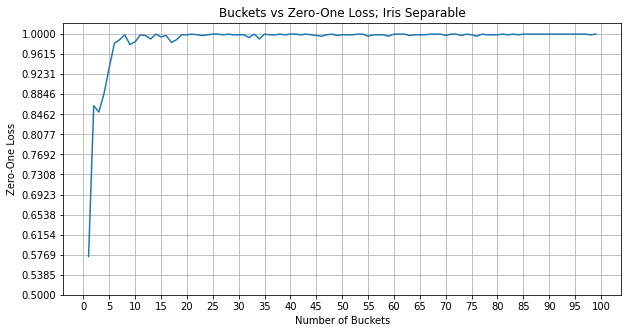

In [18]:
pd.DataFrame(iris_history).mean().plot(figsize=(10, 5))
plt.grid(True)
plt.title("Buckets vs Zero-One Loss; Iris Separable")
plt.xlabel("Number of Buckets")
plt.ylabel("Zero-One Loss")
plt.xticks(range(0, 101, 5))
plt.yticks(np.linspace(0.5, 1, 14))

<AxesSubplot:>

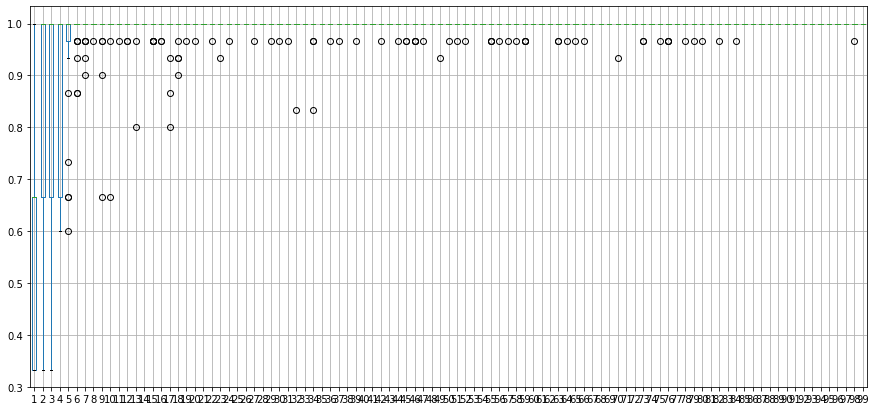

In [16]:
pd.DataFrame(iris_history).boxplot(figsize=(15, 7))

In [ ]:

def experiment(
    X,
    y,
    metric,
    test_split:   float,
    buckets:       int,
    n_runs:        int,
    verbose:       bool,
    n_buckets:     int, 
    max_iter:      int,
    eta:           float,
    ):
    
    assert len(X) == len(y), 'Shapes of input data and labels does not match!'
    
    # Bukcetize data
    training_size = int(len(X)*0.8)
    testing_size  = len(X) - training_size 
    train, test = corrupt_data(universe_len=len(X), 
                               buckets=buckets,
                               test_split=test_split)
    
    # Create dictionary to store results
    exp_data = defaultdict(lambda : [])
    
    # Experiment
    for run in range(n_runs):
        if verbose > 0:
            print(f"Start of run {run}.")
        
        
        # begin bining
        empirical_score = []
        for bins in range(1, n_buckets):

            # Create model; No innate bias included!
            model = pn.PocketPerceptron(
                input=X.shape[-1], 
                eta=eta, 
                max_iter=max_iter
            ) 
            
            # Grab training data
            m      = np.concatenate(X[train[:bins]])
            labels = np.concatenate(y[train[:bins]])
            
            if verbose > 1:
                print(f"Training with {bins} buckets -- {len(m)}")
            
            # Train model
            model.train(m, labels)
            
            # Store risk data
            if testing_size: 
                pred = model.solve(X[test])
                exp_data[bins].append(metric(y[test], pred))
            
            else: # No empirical testing. Take error over all data.
                pred = model.solve(X)
                exp_data[bins].append(metric(y, pred))

            #true_score.append(accuracy_score(y, model.solve(X)))
        #import pdb; pdb.set_trace()
    return dict(exp_data)


# Theoretical Sample complexity of Perceptron (Half-spaces)

In [103]:
def PAC_complexity(
    epsilon, 
    delta, 
    d
    ):
    """
    epsilon: Actual Error
    delta:   Probability
    d:       VC Dimension(dim(problem) + 1)
    """
    return np.math.ceil((d/epsilon) + (1/epsilon)*np.math.log10(1/delta))

def length():
    pass

def pocket_complexity(
    epsilon:      float, 
    epsilon_knot: float, 
    delta:        float, 
    p:            int,
    L:            float,
    ):
    """
    epsilon:      Actual Error of network
    epsilon_know: Measured error on training set of E
    delta:        Probability
    p:            Number of input neurons
    L:            Length of the weight vector.
    """
    a = np.math.log(8/delta)
    s = (epsilon - epsilon_knot)/epsilon
    b_min = min(2*(p+1), 4*(p+1)*np.math.log10(np.math.e))
    c = max(a, b_min * np.math.log(16/(s**2 * epsilon)))
    A = np.math.ceil((8 / (s**2 * epsilon)) * c)
    
    x = (np.math.log(1/delta) + (p+1)*np.math.log(2*L+1)) / (s**2 * epsilon)
    B = x * min(1/(2*epsilon), 2)
    return np.math.ceil(min(A, B))

In [104]:
top_cell_length_dif = [pocket_complexity(.15, .10, .95, 6, L) for L in range(1, 102, 10)]
deltas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
delta_dif = [pocket_complexity(.15, .10, d, 6, 30) for d in deltas]

<AxesSubplot:>

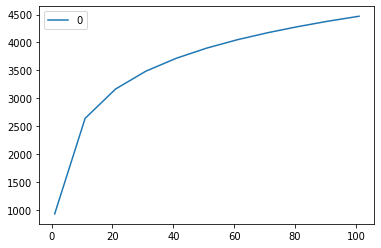

In [105]:
pd.DataFrame(top_cell_length_dif, index=range(1, 102, 10)).plot()

<AxesSubplot:>

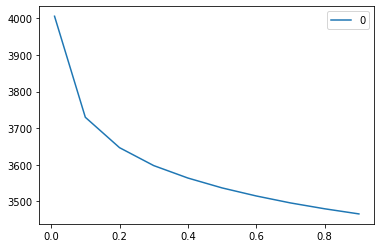

In [106]:
pd.DataFrame(delta_dif, index=deltas).plot()

In [107]:
epsilons_PAC = deltas_PAC = [0.001, 0.005, 0.01, 0.05, 0.1]
PAC_delta_diff = [PAC_complexity(0.05, d, 6) for d in deltas_PAC]
PAC_epsilon_diff = [PAC_complexity(e, 0.05, 6) for e in epsilons_PAC]

<AxesSubplot:title={'center':"PAC's change in samples w.r.t. delta probability"}>

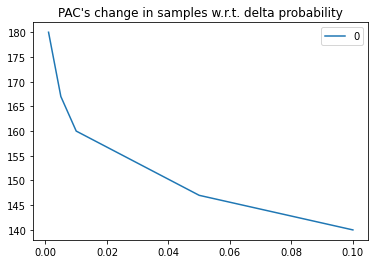

In [110]:
pd.DataFrame(PAC_delta_diff, index=deltas_PAC).plot(title="PAC's change in samples w.r.t. delta probability")

<AxesSubplot:>

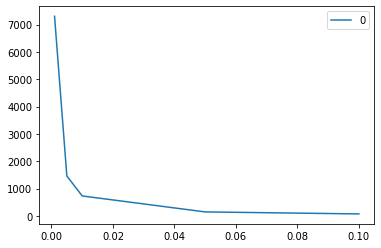

In [111]:
pd.DataFrame(PAC_epsilon_diff, index=deltas_PAC).plot()

In [133]:
delta_dict = {}
vc_dim = 5
delta = 0.05
bucket_sizes = [14 * n for n in range(1, 51)]
for delta in [0.01]:
    complexity_epsilon_dict = {
        PAC_complexity(epsilon, delta, vc_dim): epsilon for epsilon in np.linspace(0.0001, 0.5, 1000000)
    }
    delta_dict[f'Conficence: {1 - delta}'] = [complexity_epsilon_dict[m] for m in bucket_sizes]


<AxesSubplot:>

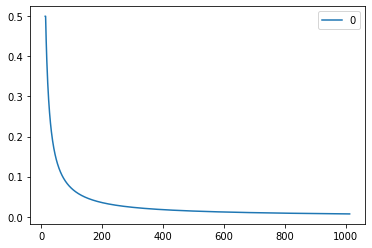

In [148]:
pd.DataFrame(complexity_epsilon_dict.values(), index=complexity_epsilon_dict.keys()).tail(1000).plot()

<AxesSubplot:>

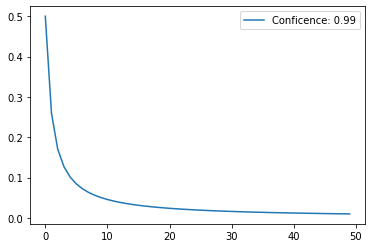

In [135]:
pd.DataFrame(delta_dict).plot()

In [160]:
def epsilon_lower_bound(n_data, vc_dim, delta):
    return (1/n_data) * (vc_dim + np.math.log(1/delta))

In [162]:
1 - epsilon_lower_bound(100, 5, 0.05)

0.9200426772644601